In [1]:
# import all relevant libraries
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import torch
from torch import nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [2]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


In [3]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100
    return acc

In [4]:
# Load the dataset and confirm it has been loaded correctly
df = pd.read_csv("bcancer_data.csv")
df.head()

,Cl.thickness,Cell.size,Cell.shape,Marg.adhesion,Epith.c.size,Bare.nuclei,Bl.cromatin,Normal.nucleoli,Mitoses,Class
0,1,1,1,1,2,1,2,1,1,0
1,5,1,1,1,1,1,3,1,1,0
2,4,1,1,1,2,1,1,1,1,0
3,2,1,1,1,2,1,2,1,1,0
4,1,2,3,1,2,1,2,1,1,0


In [5]:
# Compare the values of a few target attributes (thickness, size, and shape) for each row
x = df[["Cl.thickness", "Cell.size", "Cell.shape"]]
x.head()

,Cl.thickness,Cell.size,Cell.shape
0,1,1,1
1,5,1,1
2,4,1,1
3,2,1,1
4,1,2,3


In [6]:
# Compare the class (outcome) of each of the previously analyzed 4 rows
# 0 is negative, 1 is positive
y = df["Class"]
y.head()

,Class
0,0
1,0
2,0
3,0
4,0


In [7]:
# Create and implement the MinMaxScaler to prepare the data for Machine Learning
scaler = MinMaxScaler(feature_range = (0, 1))
x = scaler.fit_transform(x)

In [8]:
# Convert the x and y values to a PyTorch tensor of float type
x = torch.from_numpy(x).type(torch.float)
y = torch.tensor(y.values).type(torch.float)
# View the first five samples
print(f"x: {x[:5]}\n y:{y[:5]}")

x: tensor([[0.0000, 0.0000, 0.0000],
        [0.4444, 0.0000, 0.0000],
        [0.3333, 0.0000, 0.0000],
        [0.1111, 0.0000, 0.0000],
        [0.0000, 0.1111, 0.2222]])
 y:tensor([0., 0., 0., 0., 0.])


In [9]:
X_train, X_test, y_train, y_test = train_test_split(x,
                                                    y,
                                                    test_size=0.2, # 20% test, 80% train
                                                    random_state=42) # make the random split reproducible
# confirm the length of x and y to ensure the split is correct
len(X_train), len(X_test), len(y_train), len(y_test)

(432, 108, 432, 108)

In [10]:
class bCancerModel(nn.Module):
    def __init__(self, input_size=3, hidden_size=10, output_size=1):
        super().__init__()
        # Create one nn.Sequential stack that contains 2 nn.Linear layers
        # capable of handling X and y input and output shapes

        self.layer_stack = nn.Sequential(
            nn.Linear(in_features=input_size, out_features=hidden_size),
            nn.ReLU(),
            nn.Linear(in_features=hidden_size, out_features=output_size)
            )

    # Define a forward method containing the forward pass computation
    def forward(self, x):
        # Return the output of layer_stack, a single feature, the same shape as y
        return self.layer_stack(x) # computation goes through

In [11]:
# create the model
model_1 = bCancerModel()

In [12]:
# Setup loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_1.parameters(), lr=0.1)

In [13]:
# Fit the model
torch.manual_seed(42)
epochs = 100

X_train, y_train = X_train, y_train
X_test, y_test = X_test, y_test

# create lists for each epochs (every 10 epochs), loss, and accuracy to be charted later on
e = []
l = []
a = []

# Go through each epoch in the given range
for epoch in range(epochs):
    # Forward pass
    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels

    # Calculate loss and accuracy
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)

    # Optimizer zero grad
    optimizer.zero_grad()

    # Loss backward
    loss.backward()

    # Optimizer step
    optimizer.step()

    # Testing
    model_1.eval()
    with torch.inference_mode():
      # Forward pass
      test_logits = model_1(X_test).squeeze()
      test_pred = torch.round(torch.sigmoid(test_logits)) # logits -> prediction probabilities -> prediction labels
      # Calcuate loss and accuracy
      test_loss = loss_fn(test_logits, y_test)
      test_acc = accuracy_fn(y_true=y_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.4f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.4f}%")
        e.append(epoch)
        l.append(test_loss)
        a.append(test_acc)

Epoch: 0 | Loss: 0.71760, Accuracy: 45.1389% | Test Loss: 0.71878, Test Accuracy: 40.7407%
Epoch: 10 | Loss: 0.68915, Accuracy: 68.5185% | Test Loss: 0.68689, Test Accuracy: 66.6667%
Epoch: 20 | Loss: 0.66739, Accuracy: 78.7037% | Test Loss: 0.66242, Test Accuracy: 79.6296%
Epoch: 30 | Loss: 0.64810, Accuracy: 76.3889% | Test Loss: 0.64097, Test Accuracy: 77.7778%
Epoch: 40 | Loss: 0.62905, Accuracy: 76.8519% | Test Loss: 0.62012, Test Accuracy: 77.7778%
Epoch: 50 | Loss: 0.60868, Accuracy: 77.5463% | Test Loss: 0.59820, Test Accuracy: 77.7778%
Epoch: 60 | Loss: 0.58602, Accuracy: 79.8611% | Test Loss: 0.57416, Test Accuracy: 80.5556%
Epoch: 70 | Loss: 0.56042, Accuracy: 81.7130% | Test Loss: 0.54729, Test Accuracy: 83.3333%
Epoch: 80 | Loss: 0.53159, Accuracy: 85.4167% | Test Loss: 0.51736, Test Accuracy: 87.0370%
Epoch: 90 | Loss: 0.49936, Accuracy: 87.5000% | Test Loss: 0.48422, Test Accuracy: 90.7407%


In [14]:
# Output the Confusion Matrix to determine the model's results
confusion_matrix(y_test, test_pred)

array([[64,  0],
       [ 8, 36]])

In [15]:
# Extract the True Negatives, False Positives, False Negatives, and True Positives from the confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, test_pred).ravel()
(tn, fp, fn, tp)

(64, 0, 8, 36)

In [16]:
# Calculate the accuracy score
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, test_pred))

0.9259259259259259


In [17]:
# Calculate the precision
from sklearn.metrics import precision_score
print(precision_score(y_test, test_pred, average = None))

[0.88888889 1.        ]


In [18]:
# Calculate the recall
from sklearn.metrics import recall_score
print(recall_score(y_test, test_pred, average = None))

[1.         0.81818182]


In [19]:
# Convert accuracy to a measure out of 100 so it can be better compared to the loss rate
a = [x/100 for x in a]

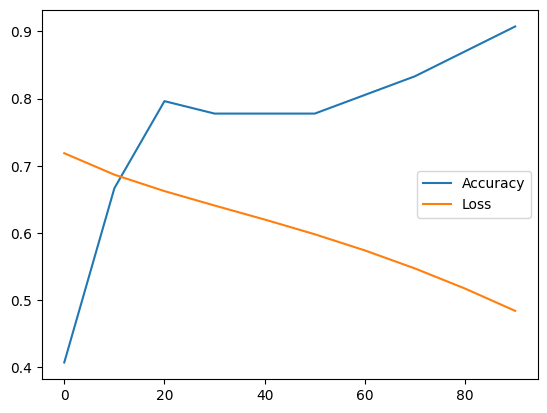

In [20]:
# Create a graph to show the inverse relationship between accuracy increasing and loss decreasing
# as the number of epochs increases

figure, aAxis = plt.subplots(sharey=True)

aAxis.plot(e, a)
aAxis.plot(e, l)

# show the legend in the plot
plt.legend(['Accuracy', 'Loss'], loc = 'center right')

# show the plot
plt.show()

In [21]:
# Conclusion: As the accuracy, precision, and recall scores are all high, we can conclude that this model is sufficient
# for predicting the outcome of the given dataset